In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
df = pd.read_csv('../data/Public_records.csv')
df_data_records = pd.read_excel('../data/Data_dictionary.xlsx')

In [4]:
# are these three columns, docket_number, plaintiff name, and attorney name just blank?
df.docket_number.isna().sum(), df.plaintiff_name.isna().sum(), df.attorney_name.isna().sum(), len(df)
#--> yes they are

(218303, 218303, 218303, 218303)

In [49]:
df_data_records['Description:'][6]

'Date when the Reporting Subscriber took cognizance of the Record in its files.'

## Number of visits

Text(0, 0.5, 'Frequency')

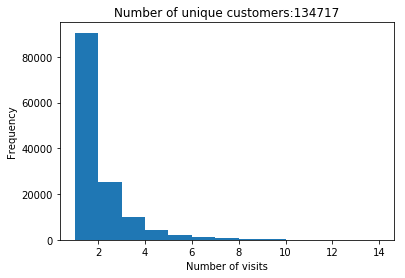

In [5]:
# How many times each customer visited
series_customer_visits = df.groupby('analytics_matchkey').size()
ax = series_customer_visits.plot(kind='hist', bins=np.arange(1, 15, 1))
ax.set_title('Number of unique customers:{}'.format(len(series_customer_visits)))
ax.set_xlabel('Number of visits')
ax.set_ylabel('Frequency')

In [6]:
# mean and std of visits
series_customer_visits.mean(), series_customer_visits.std()

(1.6204562156223787, 1.321796578399526)

In [6]:
# Maximum number of visits
print(max(series_customer_visits))
count_many_visits = 0
for i in series_customer_visits.sort_values(ascending=False):
    if i > 20:
        count_many_visits += 1
# People who visited more than 20 times:
print(count_many_visits)

87
27


In [7]:
# find if we can find clusters,,
df_customer_visits = pd.DataFrame(series_customer_visits)
df_customer_visits = df_customer_visits.rename(columns={0:'visits'})

kmeans = KMeans(n_clusters = 2, random_state=0)
kmeans.fit(df_cu12stomer_visits.visits.values.reshape(-1,1))
df_customer_visits['label'] = kmeans.labels_
# --> because customers with 1 and 2 loans are so dominant, there is no really clusters. 

## Record type

** There was no value descripts for the different record types

In [8]:
# industry code only consists of Z and ZP
df.groupby('industry_code_kind_of_business').size()


industry_code_kind_of_business
Z      19732
ZP    198571
dtype: int64

In [9]:
# public record source, most frequent types are CI, FE, RD, MU
df.groupby('public_record_source_type_code').size().sort_values(ascending=False)

public_record_source_type_code
CI    97445
FE    58896
RD    54657
MU     3291
BK     2611
SU      486
CC      219
CR      195
SC      163
DC      146
JU       53
CT       50
MA       42
CL       26
CY       11
CP        6
CA        2
CN        1
PC        1
AS        1
dtype: int64

In [10]:
# Equal Credit Opportunity Act Code: 
# Displays the contractual ownership of the public record.  
df.groupby('equal_credit_opportunity_act_code').size()

equal_credit_opportunity_act_code
C     62276
I    156027
dtype: int64

In [11]:
# Legislative Prohibited Code: 
# Identifies if the account is Medical related.   
df.groupby('legislative_prohibited_code').size()

legislative_prohibited_code
1    202909
2     15394
dtype: int64

## Size of the loans
What is the distribution of the amount

In [9]:
amount = df.amount.dropna().values
print(len(amount))
amount = amount[np.where( amount <= 15000)] #had to filter the data for plotting purposes
len(amount)

156792


149226

Text(0.5, 0, 'Loan size in $')

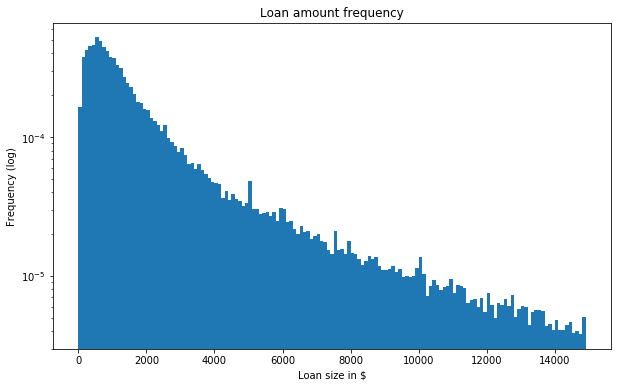

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

bins=np.arange(0, max(amount), 100)
n, bins, patches = ax.hist(amount, bins=bins, density=True)
# ax.plot(bins, expon.pdf(bins, scale=scale))
ax.set_yscale('log')
# ax.set_xlim([10, 1e4])
ax.set_title('Loan amount frequency')
ax.set_ylabel('Frequency (log)')
ax.set_xlabel('Loan size in $')

In [11]:
np.mean(amount), np.std(amount)

(2272.8220551378445, 2683.182419299598)

## Recognition of the loan payment

In [13]:
# Convert the date integers/string to datetime

def convert_to_date(x):
    try:
        return datetime.strptime(str(int(x)), '%Y%m%d')
    except ValueError:
        return np.nan
    
df['effective_date_date_verified'] = df['effective_date_date_verified'].apply(lambda x: convert_to_date(x))
df['filed_date'] = df['filed_date'].apply(lambda x: convert_to_date(x))
df['paid_date'] = df['paid_date'].apply(lambda x: convert_to_date(x))

In [14]:
print('How often the paid date is not posted')
print(df.paid_date.isna().sum()/len(df))
# does this mean the loan is not paid back or the record is just missing?

How often the paid date is not posted
0.40714969560656517


In [77]:
# Find how long it takes for a Subscriber notices of the loan after the loan is paid
# negative values mean that the loans are paid after the subscriber noticed the record before the loan was paid

df['paid_to_verified'] = df['effective_date_date_verified'] - df['paid_date']

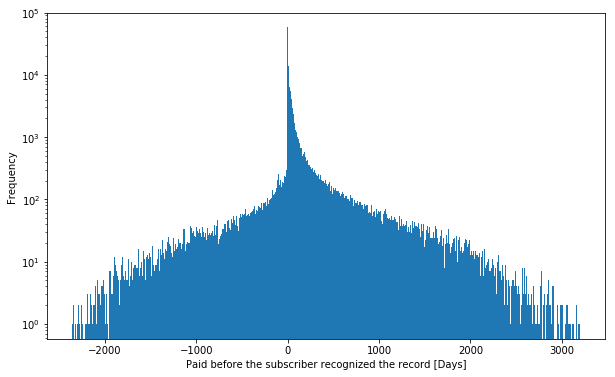

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
durations = [x.days for x in df.paid_to_verified.dropna()]
ax.hist(durations, bins=np.arange(min(durations), max(durations), 10))
ax.set_xlabel('Paid before the subscriber recognized the record [Days]')
ax.set_ylabel('Frequency')
ax.set_yscale('log')

In [79]:
df.paid_to_verified.mean(), df.paid_to_verified.std()

(Timedelta('75 days 21:52:57.314982'), Timedelta('358 days 13:19:02.612364'))

### Loan is paid always after the record is filed to the public

In [70]:
df['filed_to_paid'] = df['paid_date'] - df['filed_date']

In [74]:
df.filed_to_paid.min()

Timedelta('0 days 00:00:00')

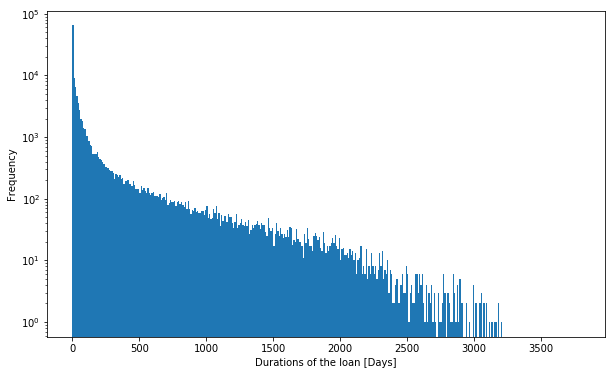

In [81]:
fig, ax = plt.subplots(figsize=(10,6))
filed_to_paid = [x.days for x in df.filed_to_paid.dropna()]
ax.hist(durations, bins=np.arange(min(filed_to_paid), max(filed_to_paid), 10))
ax.set_xlabel('Durations of the loan [Days]')
ax.set_ylabel('Frequency')
ax.set_yscale('log')

### Loan record if always filed before being verified by the subscriber

In [75]:
df['filed_to_verified'] =  df['effective_date_date_verified'] - df['filed_date']
df.filed_to_verified.min()

Timedelta('0 days 00:00:00')

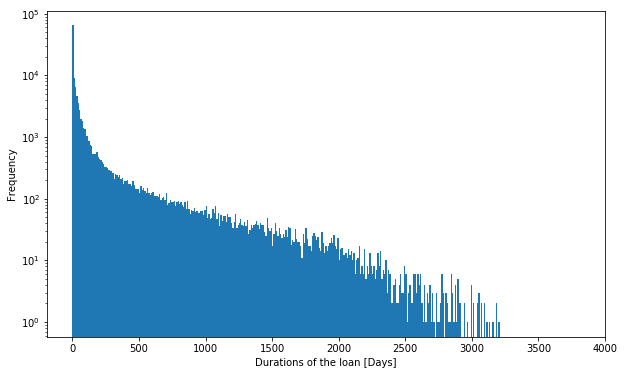

In [80]:
fig, ax = plt.subplots(figsize=(10,6))
filed_to_verified = [x.days for x in df.filed_to_verified.dropna()]
ax.hist(durations, bins=np.arange(min(filed_to_verified), max(filed_to_verified), 10))
ax.set_xlabel('Durations of the loan [Days]')
ax.set_ylabel('Frequency')
ax.set_yscale('log')

## Relation between the amount of the loan and the duration

In [102]:
# How many times is the amount record missing?
df.amount.isna().sum()/len(df)

0.2817689175137309

In [103]:
df_duration_amount = df[['loan_duration', 'amount']]
print(len(df_duration_amount))
# drop rows with na values, we will lose about 28.3% of the entire data...
df_duration_amount = df_duration_amount.dropna()
df_duration_amount['loan_duration'] = df_duration_amount.loan_duration.apply(lambda x: int(x/np.timedelta64(1, 'D')))

print(len(df_duration_amount))

218303
156549


(-100, 5000)

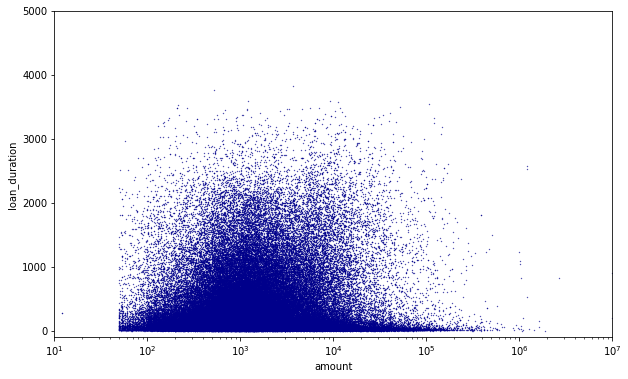

In [104]:
fig, ax = plt.subplots(figsize=(10,6))
df_duration_amount.plot.scatter(x='amount', y='loan_duration',c='DarkBlue',ax=ax,s=0.1)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([10, 10000000])
ax.set_ylim([-100, 5000])

In [107]:
example = df.iloc[0]
example

analytics_matchkey                               1346747
industry_code_kind_of_business                        ZP
reporting_subscriber_code                             99
public_record_type_code                               CJ
effective_date_date_verified         2013-06-04 00:00:00
filed_date                           2013-01-29 00:00:00
paid_date                                            NaT
amount                                              1209
public_record_source_type_code                        CI
equal_credit_opportunity_act_code                      I
legislative_prohibited_code                            1
plaintiff_name                                       NaN
attorney_name                                        NaN
docket_number                                        NaN
loan_duration                          126 days 00:00:00
Name: 0, dtype: object

In [108]:
for i, row in df_data_records.iterrows():
    print('{}: \n{}'.format(row['Variable Name:'], row['Description:']))
    print('---------------------------------------------------------------')

Analytics Matchkey: 
Unique customer identifier
---------------------------------------------------------------
Record Type: 
Code identifying record type 
---------------------------------------------------------------
Sequence Number: 
First 10 bytes is the number assigned to a consumer.Last 2 bytes are the number of times the consumer was sent in on input.
---------------------------------------------------------------
Industry Code (Kind of Business): 
A code used to categorize subscribers by their primary line of business (e.g. A=Automotive, B=Banks and S&Ls).  The second position of the code further describes kind of business. 
---------------------------------------------------------------
Reporting Subscriber Code: 
Internal trade line identifier.  The first 4 bytes are the base code, the last 3 bytes are the suffix. 
---------------------------------------------------------------
Public Record Type Code: 
Identifies the type of public record.  
--------------------------------

In [ ]:
df.head()

In [ ]:
df.amount.isna().sum()/len(df)